In [1]:
import math
import matplotlib.pyplot as plt
plt.rcParams.update({"mathtext.default": "regular"})

import numpy as np
import torch
from itertools import combinations_with_replacement
from scipy.stats import qmc
from torch import nn
from tqdm.auto import tqdm

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Рассмотрим 10 аналитически заданных функций $u(x,y; a,b) = \sin{a x}\cos{b y}$, где $a, b \in 1,2,7,14$ и $a \le b$. 
Тогда
$$-\Delta u(x,y) = (a^2 + b^2) u(x,y) = f(x,y) \Rightarrow f(x,y)=(a^2+b^2)\sin{ax}\cos{by},$$
$$u(0,y)=u(\pi, y)=0,\quad u(x, 0)=\sin{ax},\quad u(x,\pi)=(-1)^{b}\sin{ax}.$$

In [2]:
examples_cfg = list(combinations_with_replacement((1, 2, 7, 14), 2))

assert len(examples_cfg) == 10

Реализуем классы `FramePointsSampler` для сэмплирования граничных точек и `RectanglePointsSampler` для сэмплирования точек внутри области.

In [3]:
class FramePointsSampler:
    def __init__(self, x_bounds, y_bounds):
        self.l_bounds, self.u_bounds = zip(x_bounds, y_bounds)

    def sample_random(self, n_points: int = 1):
        a, c = self.l_bounds
        b, d = self.u_bounds
        data = torch.zeros((n_points, 2), dtype=torch.float32)
        ind = torch.randint(low=0, high=4, size=(n_points,))

        down, right, up, left = ind == 0, ind == 1, ind == 2, ind == 3

        data[down, 0] = a + torch.rand(down.sum(), dtype=torch.float32) * (b - a)
        data[down, 1] = c

        data[right, 0] = b
        data[right, 1] = c + torch.rand(right.sum(), dtype=torch.float32) * (d - c)

        data[up, 0] = a + torch.rand(up.sum(), dtype=torch.float32) * (b - a)
        data[up, 1] = d

        data[left, 0] = a
        data[left, 1] = c + torch.rand(left.sum(), dtype=torch.float32) * (d - c)

        data.requires_grad = True
        return data

    def sample_uniform(self, n_points: int = 3):
        assert n_points >= 3, "n_points should be greater than 3"

        horizontal_points = torch.linspace(self.l_bounds[0], self.u_bounds[0], n_points, dtype=torch.float32)
        vertical_points = torch.linspace(self.l_bounds[1], self.u_bounds[1], n_points, dtype=torch.float32)[1:-1]

        down = torch.vstack([horizontal_points, torch.zeros_like(horizontal_points)])
        up = torch.vstack([horizontal_points, torch.full_like(horizontal_points, np.pi)])
        left = torch.vstack([torch.zeros_like(vertical_points), vertical_points])
        right = torch.vstack([torch.full_like(vertical_points, np.pi), vertical_points])

        return torch.hstack([down, up, left, right]).T


class RectanglePointsSampler(qmc.LatinHypercube):
    def __init__(self, x_bounds, y_bounds):
        super(RectanglePointsSampler, self).__init__(d=2)
        self.l_bounds, self.u_bounds = zip(x_bounds, y_bounds)

    def sample_random(self, n_points: int = 1):
        data = self.random(n_points)
        data_scaled = qmc.scale(data, self.l_bounds, self.u_bounds)
        return torch.tensor(data_scaled, dtype=torch.float32, requires_grad=True)

    def sample_uniform(self, n_points: int = 3):
        assert n_points >= 3, "n_points should be greater than 3"

        horizontal_points = torch.linspace(self.l_bounds[0], self.u_bounds[0], n_points + 2, dtype=torch.float32)[1:-1]
        vertical_points = torch.linspace(self.l_bounds[1], self.u_bounds[1], n_points + 2, dtype=torch.float32)[1:-1]
        
        return torch.cartesian_prod(horizontal_points, vertical_points)

Изобразим работу генераторов точек как для случайного сэмплирования, так и для равномерной сетки.

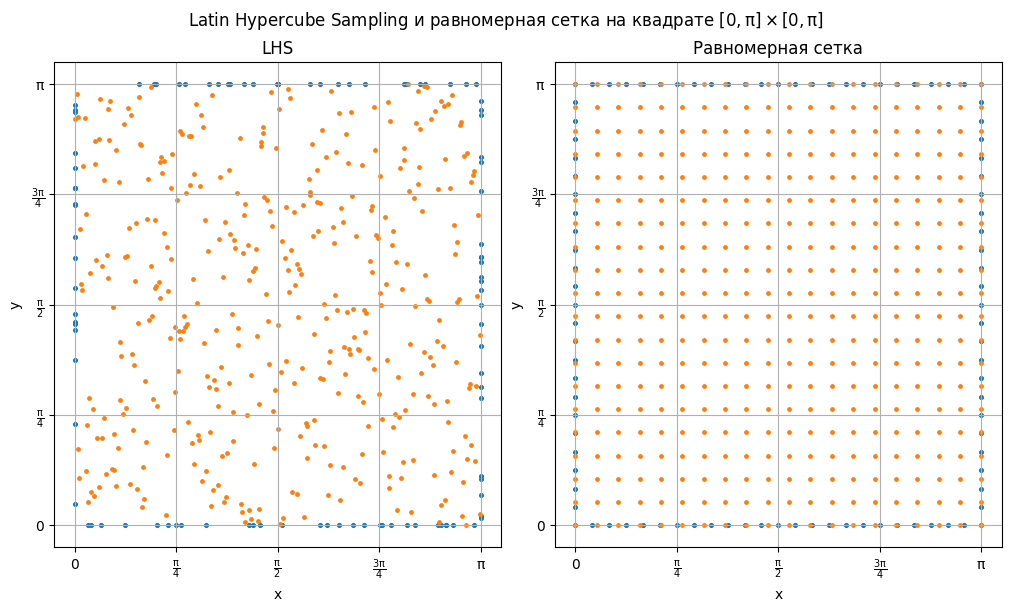

In [4]:
beautiful_labels = [r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$"]

bc_sampler = FramePointsSampler([0,np.pi], [0, np.pi])
pde_sampler = RectanglePointsSampler([0,np.pi], [0, np.pi])

with torch.no_grad():
    bc_data = bc_sampler.sample_random(100)
    pde_data = pde_sampler.sample_random(400)
    bc_grid = bc_sampler.sample_uniform(25)
    pde_grid = pde_sampler.sample_uniform(20)

    fig, ax = plt.subplots(1, 2, figsize=(10, 6), constrained_layout=True)
    fig.suptitle("Latin Hypercube Sampling и равномерная сетка на квадрате $[0,\\pi]\\times [0, \\pi]$")
    ax[0].scatter(bc_data[:, 0], bc_data[:, 1], s=7)
    ax[0].scatter(pde_data[:, 0], pde_data[:, 1], s=6)
    ax[0].set_title("LHS")
    ax[1].scatter(bc_grid[:, 0], bc_grid[:, 1], s=7)
    ax[1].scatter(pde_grid[:, 0], pde_grid[:, 1], s=6)
    ax[1].set_title("Равномерная сетка")
    for ax_i in ax:
        ax_i.set_xticks(np.linspace(0, np.pi, len(beautiful_labels)))
        ax_i.set_xticklabels(beautiful_labels)
        ax_i.set_yticks(np.linspace(0, np.pi, len(beautiful_labels)))
        ax_i.set_yticklabels(beautiful_labels)
        ax_i.set_xlabel("$x$")
        ax_i.set_ylabel("$y$")
        ax_i.grid(True)
    plt.show()

Далее реализуем полносвязный персептрон с активациями `Tanh`. Он будет служить решением задачи Дирихле для уравнения Пуассона.

In [5]:
class Dense(nn.Module):
    def __init__(self, input_size, output_size, activation=nn.Tanh):
        super(Dense, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        nn.init.xavier_uniform_(self.linear.weight)
        self.linear.bias.data.fill_(0.)
        self.activation = activation()

    def forward(self, x):
        x = self.linear(x)
        return self.activation(x)


class MLP(nn.Module):
    def __init__(self, input_size=2, output_size=1, hidden_size=75, n_layers=4, activation=nn.Tanh):
        super(MLP, self).__init__()
        self.intro = Dense(input_size, hidden_size, activation=nn.Tanh)
        self.hidden = nn.Sequential()
        for _ in range(n_layers):
            self.hidden.append(Dense(hidden_size, hidden_size, activation=nn.Tanh))
        self.outro = Dense(hidden_size, output_size, activation=nn.Identity)

    def forward(self, x):
        x = self.intro(x)
        x = self.hidden(x)
        return self.outro(x)

Убедимся, что модель корректно отрабатывает на сэмплированных множествах.

In [6]:
model = MLP()
model(bc_data).shape, model(pde_data).shape

(torch.Size([100, 1]), torch.Size([400, 1]))

Реализуем непосредственно `PINN` с возможностью обучения модели и вычисления лапласиана.

In [7]:
class PINN:
    def __init__(self, x_bounds=(0, np.pi), y_bounds=(0, np.pi)):
        self.pde_sampler = RectanglePointsSampler(x_bounds, y_bounds)
        self.bc_sampler = FramePointsSampler(x_bounds, y_bounds)

    def train(self, f, g, n_iterations=1_000, solution=None):
        model = MLP().to(DEVICE).train()
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
        criterion = nn.MSELoss(reduction="mean").to(DEVICE)

        loss_pde_history = []
        loss_bc_history = []
        loss_history = []

        for iter_num in (pbar := tqdm(range(n_iterations))):
            pde_data = self.pde_sampler.sample_random(1_000).to(DEVICE)
            bc_data = self.bc_sampler.sample_random(500).to(DEVICE)

            u_pde = model(pde_data)
            u_bc = model(bc_data)

            loss_pde = criterion(-PINN.get_laplacian(u_pde, pde_data), f(pde_data))
            loss_bc = criterion(u_bc, g(bc_data))
            loss = loss_pde + loss_bc

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (iter_num+1) % 100 == 0:
                pbar.set_description(f"Loss train: {loss.detach().cpu().item():.6f}")
                loss_pde_history.append(loss_pde.detach().cpu().item())
                loss_bc_history.append(loss_bc.detach().cpu().item())
                loss_history.append(loss.detach().cpu().item())

        model.eval()
        pde_data = self.pde_sampler.sample_random(1_000).to(DEVICE)
        bc_data = self.bc_sampler.sample_random(500).to(DEVICE)
        u_pde = model(pde_data)
        u_bc = model(bc_data)
        u = torch.vstack([u_pde, u_bc])

        if solution is not None:
            u_pde_true = solution(pde_data)
            u_bc_true = solution(bc_data)
            u_true = torch.vstack([u_pde_true, u_bc_true])
            print(
                f"Solution L2 absolute error: {torch.linalg.norm(u_true - u, ord=2)}",
                f"Solution L2 relative error: {torch.linalg.norm(u_true - u, ord=2) / torch.linalg.norm(u, ord=2)}",
                f"Solution C absolute error: {torch.abs(u_true - u).max()}",
                f"Solution C relative error: {torch.abs(u_true - u).max() / torch.abs(u_true).max()}",
                sep="\n"
            )

        residual = -PINN.get_laplacian(u_pde, pde_data) - f(pde_data)
        print(
            f"Residual L2 error: {torch.linalg.norm(residual, ord='fro')}",
            f"Residual C error: {torch.abs(residual).max()}",
            sep="\n"
        )

        losshistory = {
            "pde_loss": loss_pde_history,
            "bc_loss": loss_bc_history,
            "loss": loss_history
        }
        return model, losshistory

    @staticmethod
    def get_laplacian(u, inputs):
        du = torch.autograd.grad(
            u,
            inputs,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        dudu = torch.autograd.grad(
            du,
            inputs,
            grad_outputs=torch.ones_like(du),
            create_graph=True,
            retain_graph=True
        )[0]
        return dudu[:, 0:1] + dudu[:, 1:2]

In [8]:
def get_f(a, b):
    def f(x):
        return (a**2 + b**2) * torch.sin(a * x[:, 0:1]) * torch.cos(b * x[:, 1:2])
    return f


def get_g(a, b):
    def g(x):
        boundary = torch.zeros_like(x[:, 0])
        on_bottom = torch.isclose(x[:, 1], torch.tensor(0.))
        on_top = torch.isclose(x[:, 1], torch.tensor(np.pi))
        boundary[on_bottom] = torch.sin(a * x[:, 0])[on_bottom]
        boundary[on_top] = (-1)**b * torch.sin(a * x[:, 0])[on_top]
        return boundary.reshape(-1, 1)
    return g


def get_solution(a, b):
    def solution(x):
        return torch.sin(a * x[:, 0:1]) * torch.cos(b * x[:, 1:2])
    return solution

In [9]:
n_iterations = 30_000

In [10]:
results = {}
for a, b in examples_cfg:
    print("\n\n============================================")
    print(f"Training model for u(x,y)=sin({a}x)*cos({b}y)")

    f = get_f(a, b)
    g = get_g(a, b)
    solution = get_solution(a, b)
    solution_repr = r"$u(x,y)=\sin{" + str(a) + r"x}\cdot\cos{" + str(b) + "y}$"
    pinn = PINN()
    model, losshistory = pinn.train(f, g, n_iterations=n_iterations, solution=solution)

    results[(a, b)] = {
        "f": f,
        "g": g,
        "solution": solution,
        "solution_repr": solution_repr,
        "model": model,
        "losshistory": losshistory
    }



Training model for u(x,y)=sin(1x)*cos(1y)


  0%|          | 0/30000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Solution L2 absolute error: 8.680002212524414
Solution L2 relative error: 0.3699481189250946
Solution C absolute error: 0.5553994178771973
Solution C relative error: 0.555399477481842
Residual L2 error: 0.06178584694862366
Residual C error: 0.006662428379058838


Training model for u(x,y)=sin(1x)*cos(2y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 20.610750198364258
Solution L2 relative error: 0.6439400911331177
Solution C absolute error: 1.72555410861969
Solution C relative error: 1.725554347038269
Residual L2 error: 0.24076038599014282
Residual C error: 0.035179056227207184


Training model for u(x,y)=sin(1x)*cos(7y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 5.949810028076172
Solution L2 relative error: 0.2807020843029022
Solution C absolute error: 0.3303440511226654
Solution C relative error: 0.3303612470626831
Residual L2 error: 2.609032154083252
Residual C error: 0.6589999198913574


Training model for u(x,y)=sin(1x)*cos(14y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 8.022544860839844
Solution L2 relative error: 0.3641228675842285
Solution C absolute error: 0.7400210499763489
Solution C relative error: 0.7400332093238831
Residual L2 error: 60.09941482543945
Residual C error: 10.02960205078125


Training model for u(x,y)=sin(2x)*cos(2y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 42.40167999267578
Solution L2 relative error: 0.7978950142860413
Solution C absolute error: 3.1380629539489746
Solution C relative error: 3.1383047103881836
Residual L2 error: 1.053346872329712
Residual C error: 0.12043559551239014


Training model for u(x,y)=sin(2x)*cos(7y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 15.433318138122559
Solution L2 relative error: 0.5455961227416992
Solution C absolute error: 0.9543423652648926
Solution C relative error: 0.9543607831001282
Residual L2 error: 7.75248908996582
Residual C error: 1.1971912384033203


Training model for u(x,y)=sin(2x)*cos(14y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 27.812759399414062
Solution L2 relative error: 0.7614745497703552
Solution C absolute error: 2.334562063217163
Solution C relative error: 2.3357481956481934
Residual L2 error: 144.78564453125
Residual C error: 19.002639770507812


Training model for u(x,y)=sin(7x)*cos(7y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 156.5150146484375
Solution L2 relative error: 1.0114781856536865
Solution C absolute error: 13.85795783996582
Solution C relative error: 13.857967376708984
Residual L2 error: 777.7662963867188
Residual C error: 60.64622116088867


Training model for u(x,y)=sin(7x)*cos(14y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 88.81561279296875
Solution L2 relative error: 0.9449200630187988
Solution C absolute error: 9.776983261108398
Solution C relative error: 9.776988983154297
Residual L2 error: 1228.1468505859375
Residual C error: 209.2054443359375


Training model for u(x,y)=sin(14x)*cos(14y)


  0%|          | 0/30000 [00:00<?, ?it/s]

Solution L2 absolute error: 75.73783874511719
Solution L2 relative error: 1.0168105363845825
Solution C absolute error: 3.9715468883514404
Solution C relative error: 3.971991777420044
Residual L2 error: 4585.525390625
Residual C error: 397.4269714355469


In [11]:
cmap="gist_rainbow_r"

arr_to_img = lambda arr, n: arr.reshape(n, n).T

@torch.no_grad()
def plot_model(model_cfg, N):
    xy = pde_sampler.sample_uniform(N)
    solution, solution_repr, model = (model_cfg[attr] for attr in ("solution", "solution_repr", "model"))
    model = model.to("cpu")
    u_true, u_pred = solution(xy).numpy(), model(xy).numpy()

    norm_repr = r"$\| u - model \|_{C}$"
    plots_config = [
        (0, arr_to_img(u_true, N), model_cfg["solution_repr"], beautiful_labels, beautiful_labels),
        (1, arr_to_img(u_pred, N), "model", beautiful_labels, beautiful_labels),
        (2, arr_to_img(np.abs(u_pred - u_true), N), norm_repr, beautiful_labels, beautiful_labels),
    ]
    
    fig, ax = plt.subplots(1, 3, figsize=(10, 8), constrained_layout=True)
    
    for plot_num, cfg in enumerate(plots_config):
        i, data, title, xlabels, ylabels = cfg
        img = ax[i].imshow(data[:, ::-1], cmap=cmap)
        plots_config[plot_num] = cfg + (img, )
        ax[i].set_title(title)
        ax[i].set_xlabel("x")
        ax[i].set_ylabel("y")
        if len(xlabels) > 0:
            ax[i].set_xticks(np.linspace(0, N, len(xlabels)))
            ax[i].set_xticklabels(xlabels)
        else:
            ax[i].set_xticks([])
        if len(ylabels) > 0:
            ax[i].set_yticks(np.linspace(0, N, len(ylabels))[::-1])
            ax[i].set_yticklabels(ylabels)
        else:
            ax[i].set_yticks([])
    
    
    cbar_u = plt.colorbar(plots_config[1][-1], ax=(ax[0], ax[1]), shrink=0.4)
    cbar_d = plt.colorbar(plots_config[2][-1], ax=ax[2], shrink=0.3)
    
    for cbar in (cbar_u, cbar_d):
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
    
    plt.show()

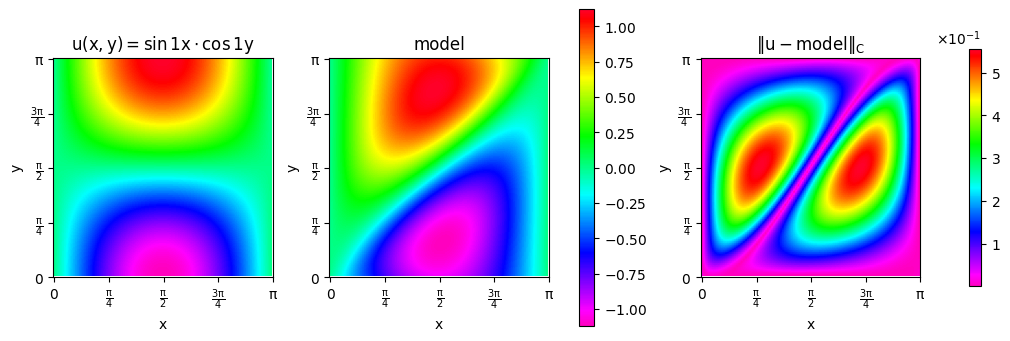

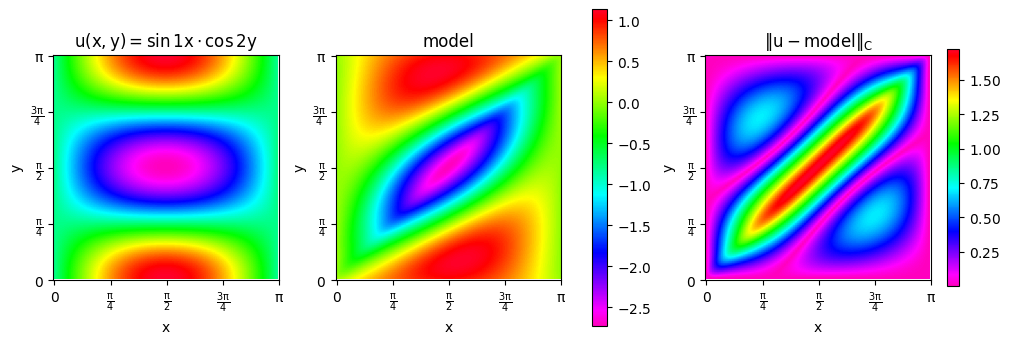

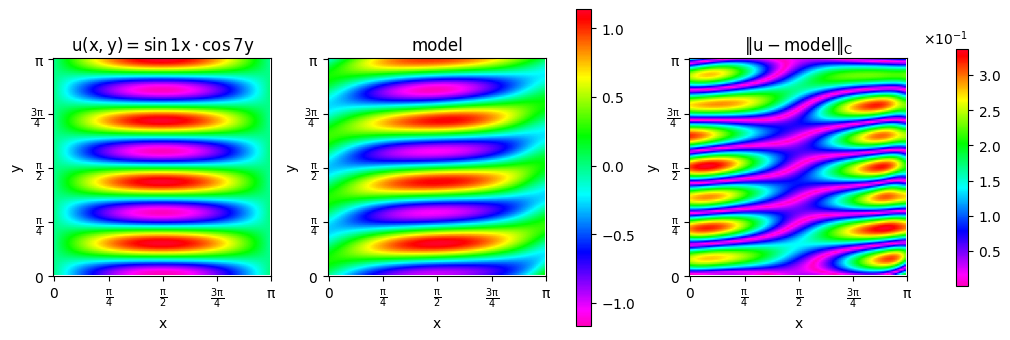

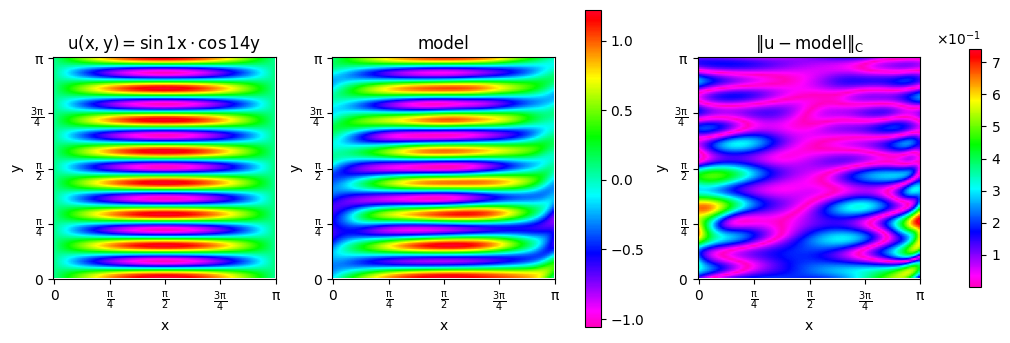

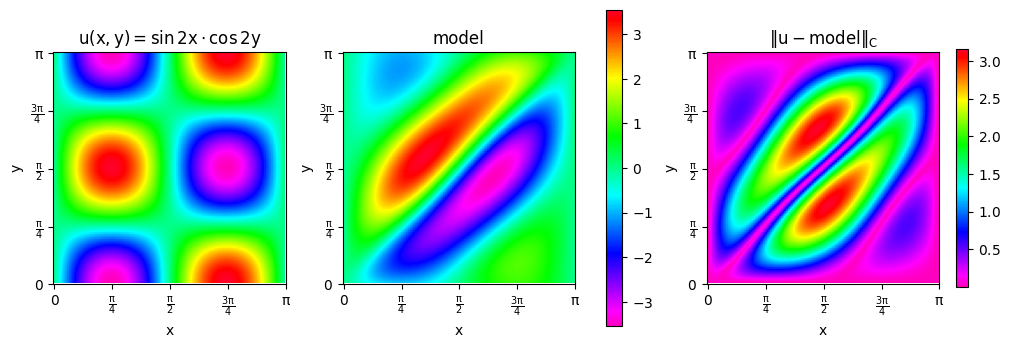

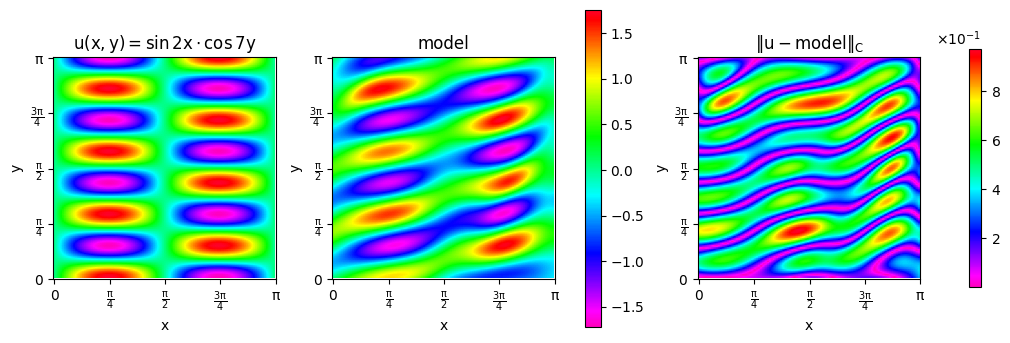

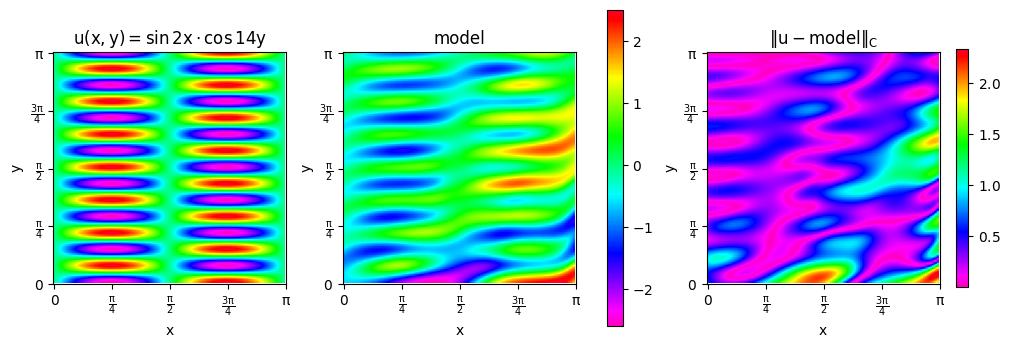

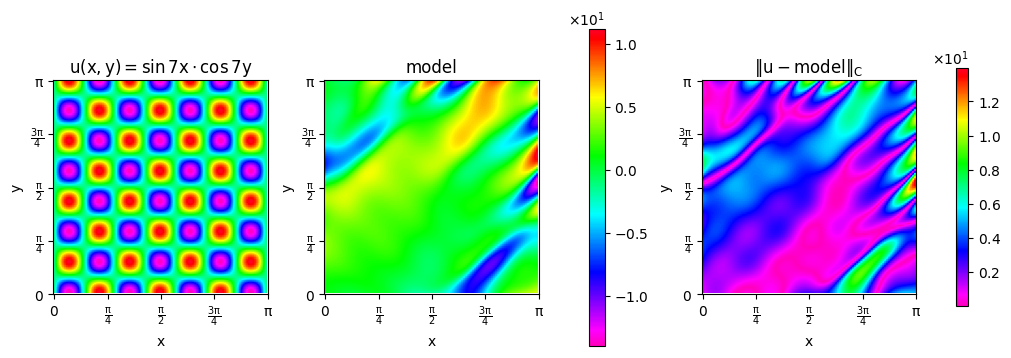

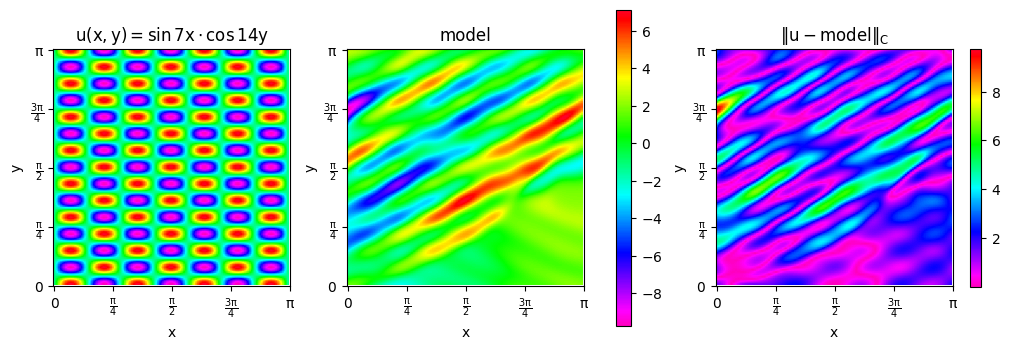

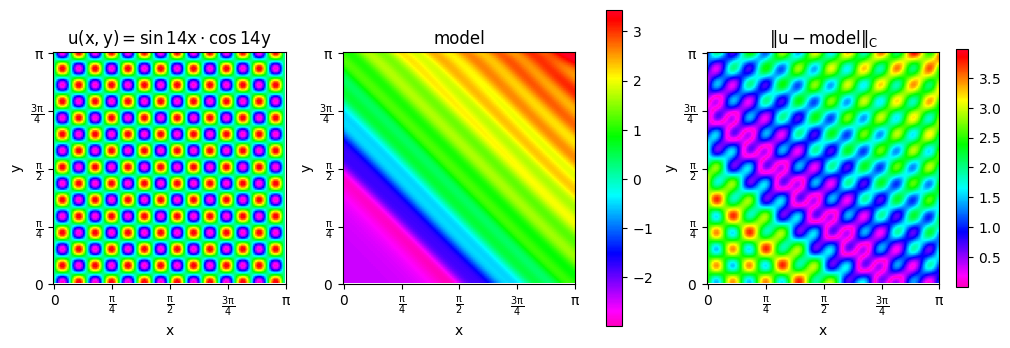

In [12]:
for frequencies in examples_cfg:
    plot_model(results[frequencies], 100)